## Complex Feature Model

The model(s) that follow are intended to be more complex than those in the Naive and Common Features models. These may include:
* Dummied Features
* Many more features 
* Use of regularization, scaling, and normalization
* Further exploration of bias and variance tradeoffs

### Cleaning and EDA

In [1]:
#standard imports
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#modeling imports
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [2]:
#load in the data
train = pd.read_csv('./datasets/train_data_cleaned_v2') #after the updates
train.drop(columns= ['Unnamed: 0'], inplace=True)
train.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,60,RL,0.0,13517,Pave,no,IR1,Lvl,AllPub,CulDSac,...,0,0,0,no,0,0,3,2010,WD,130500
1,60,RL,43.0,11492,Pave,no,IR1,Lvl,AllPub,CulDSac,...,0,0,0,no,0,0,4,2009,WD,220000
2,20,RL,68.0,7922,Pave,no,Reg,Lvl,AllPub,Inside,...,0,0,0,no,0,0,1,2010,WD,109000
3,60,RL,73.0,9802,Pave,no,Reg,Lvl,AllPub,Inside,...,0,0,0,no,0,0,4,2010,WD,174000
4,50,RL,82.0,14235,Pave,no,IR1,Lvl,AllPub,Inside,...,0,0,0,no,0,0,3,2010,WD,138500


In [3]:
#recheck for any nulls or weirdness
train.isna().sum().sum()

0

In [4]:
#only 6 lets fill those and resave it
train.fillna(0, inplace=True)

In [5]:
train.isna().sum().sum()

0

In [6]:
#train.to_csv('./datasets/train_data_cleaned_v2')

In [7]:
train.dtypes

ms_subclass       int64
ms_zoning        object
lot_frontage    float64
lot_area          int64
street           object
                 ...   
misc_val          int64
mo_sold           int64
yr_sold           int64
sale_type        object
saleprice         int64
Length: 79, dtype: object

In [8]:
train.head(3)

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,60,RL,0.0,13517,Pave,no,IR1,Lvl,AllPub,CulDSac,...,0,0,0,no,0,0,3,2010,WD,130500
1,60,RL,43.0,11492,Pave,no,IR1,Lvl,AllPub,CulDSac,...,0,0,0,no,0,0,4,2009,WD,220000
2,20,RL,68.0,7922,Pave,no,Reg,Lvl,AllPub,Inside,...,0,0,0,no,0,0,1,2010,WD,109000


In [9]:
train[train['ms_subclass'] == 150]

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1514,150,RL,0.0,1700,Pave,no,Reg,HLS,AllPub,Inside,...,200,0,0,no,0,0,4,2006,WD,148400


In [10]:
#we know from the common features model that the test data set does not have any values that are ms_subclass == 150, so we drop the one here
#150 is a 1-1/2 story PUD or planned unit development this article (https://www.redfin.com/guides/what-is-a-planned-unit-development) suggests it is similar to a condo or townhouse
train.drop([1514], inplace= True)

### Let's Try a Kitchen Sink Model

In [11]:
#not duplicates
#train[['condition_1', 'condition_2']].sort_values('condition_1')

In [12]:
#pd.get_dummies(train['misc_feature'], drop_first=True)

In [13]:
### One Hot Encode or Dummy variables to transform categorical variables into a format that can be used in regression
ms_subclass = pd.get_dummies(data=train['ms_subclass'], prefix= 'ms_subclass', drop_first=True)
ms_zoning   = pd.get_dummies(data=train['ms_zoning'], prefix= 'ms_zoning', drop_first=True)
street      = pd.get_dummies(data=train['street'], prefix= 'access_', drop_first=True)
alley       = pd.get_dummies(data=train['alley'], prefix= 'alley_', drop_first=True)
land_countour = pd.get_dummies(data=train['land_contour'], prefix= 'land_contour_', drop_first=True)
lot_config  = pd.get_dummies(data=train['lot_config'], prefix= 'lot_config_', drop_first=True)
neighborhood  = pd.get_dummies(data=train['neighborhood'], prefix='neighborhood_', drop_first=True)
condition_1 = pd.get_dummies(train['condition_1'], prefix= 'cnd_1_', drop_first=True)
condition_2 = pd.get_dummies(train['condition_2'], prefix= 'cnd_2_', drop_first=True)
bldg_type   = pd.get_dummies(train['bldg_type'], prefix= 'bldg_type_', drop_first=True)
house_style  = pd.get_dummies(train['house_style'], prefix= 'house_style_', drop_first=True)
roof_style  = pd.get_dummies(train['roof_style'], prefix= 'roof_style_', drop_first=True)
roof_matl   = pd.get_dummies(train['roof_matl'], prefix= 'roof_matl_', drop_first=True)
extr_1      = pd.get_dummies(train['exterior_1st'], prefix = 'ext_1_', drop_first=True)
extr_2      = pd.get_dummies(train['exterior_2nd'], prefix = 'ext_2_', drop_first=True)
mas_vnr_type = pd.get_dummies(train['mas_vnr_type'], prefix = 'mas_vnr_type_', drop_first=True)
foundation  = pd.get_dummies(train['foundation'], prefix= 'foundation_', drop_first=True)
heating     = pd.get_dummies(train['heating'], prefix= 'heating_', drop_first=True)
central_air = pd.get_dummies(train['central_air'], prefix= 'central_air_', drop_first=True)
garage_type = pd.get_dummies(train['garage_type'], prefix= 'garage_type', drop_first=True)
misc_feat   = pd.get_dummies(train['misc_feature'], prefix='misc_feat_', drop_first=True)

dummies=[ms_subclass, ms_zoning, street, alley, land_countour, lot_config, neighborhood, condition_1, condition_2, bldg_type, house_style, roof_style, roof_matl,
        extr_1, extr_2, mas_vnr_type, foundation, heating, central_air, garage_type, misc_feat]

In [14]:
for dummy in dummies:
    train = train.join(other=dummy)
    
print(train.columns)

Index(['ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config',
       ...
       'garage_type_2Types', 'garage_type_Attchd', 'garage_type_Basment',
       'garage_type_BuiltIn', 'garage_type_CarPort', 'garage_type_Detchd',
       'misc_feat__Gar2', 'misc_feat__Othr', 'misc_feat__Shed',
       'misc_feat__TenC'],
      dtype='object', length=222)


In [15]:
# casting/mapping out ordinal variables
train['lot_shape'] = train['lot_shape'].map({'Reg': 4, 'IR1' : 3, 'IR2' : 2, 'IR3' : 1})
train['utilities'] = train['utilities'].map({'AllPub': 1, 'NoSewr' : 0, 'NoSeWa' : 0, 'ELO' : 0})
train['land_slope'] = train['land_slope'].map({'Gtl' : 3, 'Mod': 2, 'Sev': 1})
train['bsmt_cond'] = train['bsmt_cond'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1,})
train['bsmt_exposure'] = train['bsmt_exposure'].map({'Gd': 3, 'Av' : 2, 'Mn' : 1, 'No' : 0, 0: 0})
train['bsmtfin_type_1'] = train['bsmtfin_type_1'].map({'GLQ' : 4, 'ALQ' : 3, 'BLQ' : 2, 'Rec' : 3, 'LwQ' : 1, 'Unf' : 1, 0 : 0})
train['bsmtfin_type_2'] = train['bsmtfin_type_2'].map({'GLQ' : 4, 'ALQ' : 3, 'BLQ' : 2, 'Rec' : 3, 'LwQ' : 1, 'Unf' : 1, 0 : 0})
train['heating_qc'] = train['heating_qc'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1})
train['electrical'] = train['electrical'].map({'Sbrkr' : 4, 'FuseA' : 3, 'FuseF' : 2, 'FuseP' : 1, 'Mix' : 2})
train['kitchen_qual'] = train['kitchen_qual'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1})
train['functional'] = train['functional'].map({'Typ': 7, 'Min1' : 6, 'Min2' : 5, 'Mod' : 4, 'Maj1' : 3, 'Maj2' : 2, 'Sev' : 1, 'Sal' : 0})
train['fireplace_qu'] = train['fireplace_qu'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1, 0 : 0})
train['garage_finish'] = train['garage_finish'].map({'Fin': 3, 'RFn' : 2, 'Unf' : 1, 0 :0})
train['garage_qual'] = train['garage_qual'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1})
train['garage_cond'] = train['garage_cond'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 0 : 0})
train['paved_drive'] = train['paved_drive'].map({'Y' : 2, 'P' : 1, 'N' : 0})
train['pool_qc'] = train['pool_qc'].map({'Ex' : 4, 'Gd' : 3, 'TA' : 2, 'Fa' : 1, 0 : 0})
train['fence'] = train['fence'].map({'GdPrv': 4, 'MnPrv' : 3, 'GdWo' : 2, 'MnWw' : 1, 'no' : 0})
train['exter_cond'] = train['exter_cond'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1, 0 : 0})
train['exter_qual'] = train['exter_qual'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1, 0 : 0})

In [16]:
train.isna().sum().sum()

5470

In [17]:
#itrated through above columns to ensure they have no nulls
train['exter_qual'].isna().sum()

0

In [18]:
train['exter_qual'] = train.exter_qual.map(lambda exter_qual : int(exter_qual))

In [19]:
train['exter_qual'].value_counts()

3    1247
4     696
5      79
2      26
Name: exter_qual, dtype: int64

In [20]:
def col_to_int_no_nulls(col):
    if train[col].isna().sum() <1:
            train[col] = train[col].map(lambda col : int(col))
    else:
        train[col].fillna(0, inplace = True)
        train[col] = train[col].map(lambda col : int(col))
    
    return train[col].value_counts()

In [24]:
features = train.drop(columns= 'saleprice')

In [32]:
[col_to_int_no_nulls(col) for col in features if type(col) == float]

[]

In [50]:
col_to_int_no_nulls('exter_qual')

3    1247
4     696
5      79
2      26
Name: exter_qual, dtype: int64

In [51]:
#feature interactions 
train['total_sf'] = train['total_bsmt_sf'] + train['gr_liv_area']

train['overalls'] = train['overall_cond'] * train['overall_qual']

train['extr_overalls'] = train['exter_cond'] * train['exter_qual']

train['bedbathbynd']  = train['full_bath'] * train['totrms_abvgrd'] * train['bedroom_abvgr']

train['bsmt_overall'] = train['bsmt_cond'] * train['bsmt_qual']

train['garage_overalls'] = train['garage_qual'] * train['garage_cond'] * train['garage_finish'] * train['garage_cars']

In [52]:
#from hackathon find found here (https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas)
numerics = ['uint8', 'float64', 'int32', 'float16', 'float32', 'int64']

train_numeric = train.select_dtypes(include=numerics)

In [53]:
train_numeric.isna().sum()

ms_subclass        0
lot_frontage       0
lot_area           0
lot_shape          0
utilities          0
                  ..
total_sf           0
overalls           0
extr_overalls      0
bedbathbynd        0
garage_overalls    0
Length: 205, dtype: int64

In [54]:
train_numeric.shape

(2048, 205)

We now have a very large dataframe, with a number of features. However we need to drop the columns that were used to create the feature interactions to protect against multicollinearity. 

In [55]:
train['2nd_flr_sf'] 

0        754
1       1209
2          0
3        700
4        614
        ... 
2044       0
2045       0
2046     741
2047       0
2048     776
Name: 2nd_flr_sf, Length: 2048, dtype: int64

In [58]:
train_numeric.drop(columns=['total_bsmt_sf', 'gr_liv_area', 'overall_cond', 'overall_qual', 'exter_cond', 'exter_qual', 'full_bath', 'half_bath', 'totrms_abvgrd',
                            'bedroom_abvgr', 'bsmt_cond', 'garage_qual', 'garage_cond', 'garage_finish', 'garage_cars', '1st_flr_sf', '2nd_flr_sf'], inplace=True)

In [119]:
#additional features to drop that are not in the test set
train_numeric.drop(columns=['ms_zoning_C (all)','alley__no', 'neighborhood__GrnHill','neighborhood__Landmrk','cnd_2__Feedr','cnd_2__PosN','cnd_2__RRAe','cnd_2__RRAn',
                   'cnd_2__RRNn', 'roof_matl__Membran', 'ext_1__CBlock', 'ext_1__ImStucc', 'ext_1__Stone', 'ext_2__Stone', 'heating__OthW', 'heating__Wall', 'garage_type_2Types',
                    'misc_feat__Gar2', 'misc_feat__TenC'], inplace= True)

In [125]:
#saleprice = train['saleprice']

In [130]:
#train_numeric = train_numeric.join(other= saleprice)

In [120]:
#need to regularize the year built/remodeled to have an accurate age of the houses as opposed to just the year
#the max year is 2010, so we'll set is as 2010 - year
train_numeric['year_built']     = 2010 - train_numeric['year_built']
train_numeric['year_remod/add'] = 2010 - train_numeric['year_remod/add']

In [131]:
#fitting variables and using a 1/3 test, 2/3 train split
X = train_numeric.drop(columns= 'saleprice')
y = train_numeric['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3792, train_size= .66)

In [132]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [133]:
round(lr.score(X_train, y_train), 4)

0.9284

In [134]:
round(lr.score(X_test, y_test), 4)

0.8929

In [135]:
# We have an underfit model, it is prediciting higher than some of the other models, but its still a large discrepancy between the train and test

#### Regularization & Scaling

In [136]:
#we need to scale our data first before using a Lasso or ridge model
sc = StandardScaler ()
X_train_sc = sc.fit_transform(X_train)
X_test_sc  = sc.fit_transform(X_test)

In [137]:
X_train_sc.shape

(1351, 168)

In [138]:
X_test_sc.shape

(697, 168)

In [139]:
#lets check how our scaled data looks before we use regularization
lr_sc = LinearRegression()
lr_sc.fit(X= X_train_sc, y= y_train)

LinearRegression()

In [140]:
#still not great
print(round(lr_sc.score(X_train_sc, y_train), 4)), print(round(lr_sc.score(X_test_sc, y_test), 4))

0.9284
-8.252431880959403e+21


(None, None)

In [141]:
#ridge instaniation
ridge_model = RidgeCV(alphas= 10)

#fit
ridge_model.fit(X_train_sc, y_train)

#scores
print(round(ridge_model.score(X_train_sc, y_train), 4))
print(round(ridge_model.score(X_test_sc, y_test), 4))

0.9277
0.8879


This is a bit of an improvement from the initial model above, but we've still got about a 4% point difference between the test and the training scores. Before moving over to Lasso lets see if we can use a brute force method to improve Ridge further.

In [142]:
#example from the 3.06 regularization lesson
#np.logspae will generate 100 values between 0 and 5 and then convert to 10^0 and 10^5
r_alphas = np.logspace(0, 5, 100)

#cross validate over the list of values
ridge_cv = RidgeCV(alphas= r_alphas, scoring= 'r2', cv= 5)

#fit the model using the best option from ridge
ridge_cv = ridge_model.fit(X_train, y_train)

In [143]:
#the optimal value of alpha is 10 which is what we used initially, we can move over to LASSO now and see if that improves the model further
ridge_cv.alpha_

10

In [144]:
#lasso model instantiate, set CV to 5, max iterations to 50,000
lasso_cv = LassoCV(cv= 5, max_iter= 50_000)

#fit the model
lasso_cv.fit(X_train_sc, y_train)

LassoCV(cv=5, max_iter=50000)

In [145]:
#lets check the coefficients first, seems like we have kept the majority of the variables
lasso_cv.coef_

array([-3.59711553e+03,  1.70379560e+03,  3.65604468e+03, -0.00000000e+00,
       -7.88876154e+01,  2.65122489e+02, -1.05092323e+04, -7.74011447e+02,
        1.03110141e+04,  4.85893073e+03, -3.00982739e+02,  0.00000000e+00,
       -0.00000000e+00, -1.63801159e+03, -9.58117048e+03,  7.52919698e+02,
        4.82999497e+02, -2.65920217e+02,  6.06702977e+02, -1.09468091e+03,
       -5.06255846e+02,  6.54158665e+03,  2.41266947e+03,  2.43482134e+03,
        9.67358911e+02, -1.84999376e+03,  4.76545269e+03, -0.00000000e+00,
        1.57217089e+03,  1.00303681e+02,  0.00000000e+00, -7.00731326e+02,
        3.23982335e+03,  0.00000000e+00,  1.22293943e+03, -6.41910901e+02,
        5.15355371e+01, -0.00000000e+00, -4.78560627e+02,  1.12283841e+03,
       -0.00000000e+00,  3.05986710e+02,  5.13428410e+02,  1.00441544e+03,
        4.03663596e+02,  0.00000000e+00,  0.00000000e+00, -3.02290023e+02,
       -1.63371622e+03, -2.08911224e+03, -2.37701327e+03, -0.00000000e+00,
       -0.00000000e+00,  

In [146]:
#scoring check
print(round(lasso_cv.score(X_train_sc, y_train), 4))
print(round(lasso_cv.score(X_test_sc, y_test), 4))

0.9233
0.893


We have further improved the model, but we still have a biased and underfit model as we are still about 3% points different between the training score and the test score. Still lets look at which of the long list of Coefficients are positively impacting the model.

In [147]:
coefficients = pd.DataFrame(zip(X_test.columns, lasso_cv.coef_), columns= ['Feature', 'Coefficient'])

In [148]:
#lets look at just the positive coefficients
positive_coefs = coefficients[coefficients['Coefficient'] > 0]
positive_coefs.head()

,Feature,Coefficient
1,lot_frontage,1703.795596
2,lot_area,3656.044680
5,land_slope,265.122489
8,mas_vnr_area,10311.014145
9,bsmt_exposure,4858.930733


In [152]:
#lets look at a summary of the positive coeffs, out of the 160+ coefficients only 67 were positive
positive_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
Coefficient,67.0,2312.357273,4517.790569,13.746055,354.825153,1084.771032,2423.745404,33900.492523


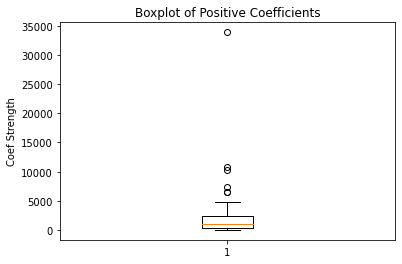

In [153]:
plt.boxplot(positive_coefs['Coefficient'], meanline= True)

plt.title('Boxplot of Positive Coefficients')

plt.ylabel(ylabel= 'Coef Strength')

plt.s;

This box plot gives a clear indication that are a number of outliers that appear to be heavily influening the model. The biggest of these appears to be having a huge impact. In the context of this project and predicting housing prices those outliers are likely to be of high importance to understand what is influencing the price of a home in Ames, IA.

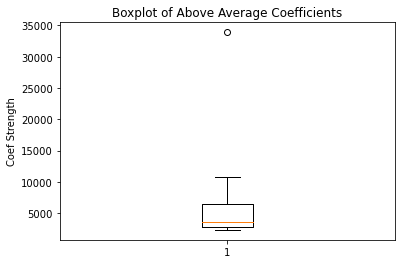

In [155]:
#Lets zoom in a bit and look at another box plot using only the coefficients that are above the mean (>2440)
abv_av_coefs = coefficients[coefficients['Coefficient'] > 2312]

plt.boxplot(abv_av_coefs['Coefficient'], meanline= True)

plt.title('Boxplot of Above Average Coefficients')

plt.ylabel(ylabel= 'Coef Strength');

In [157]:
#We only have one outlier remaining from the initial box plot, the rest now appear to be on the final end of the plot line.
#we also have gone from 68 positive coefficients to now just 19 that are above the average for the positive coefficients
abv_av_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
Coefficient,19.0,6180.182515,7192.764595,2346.851531,2785.690652,3656.04468,6545.241453,33900.492523


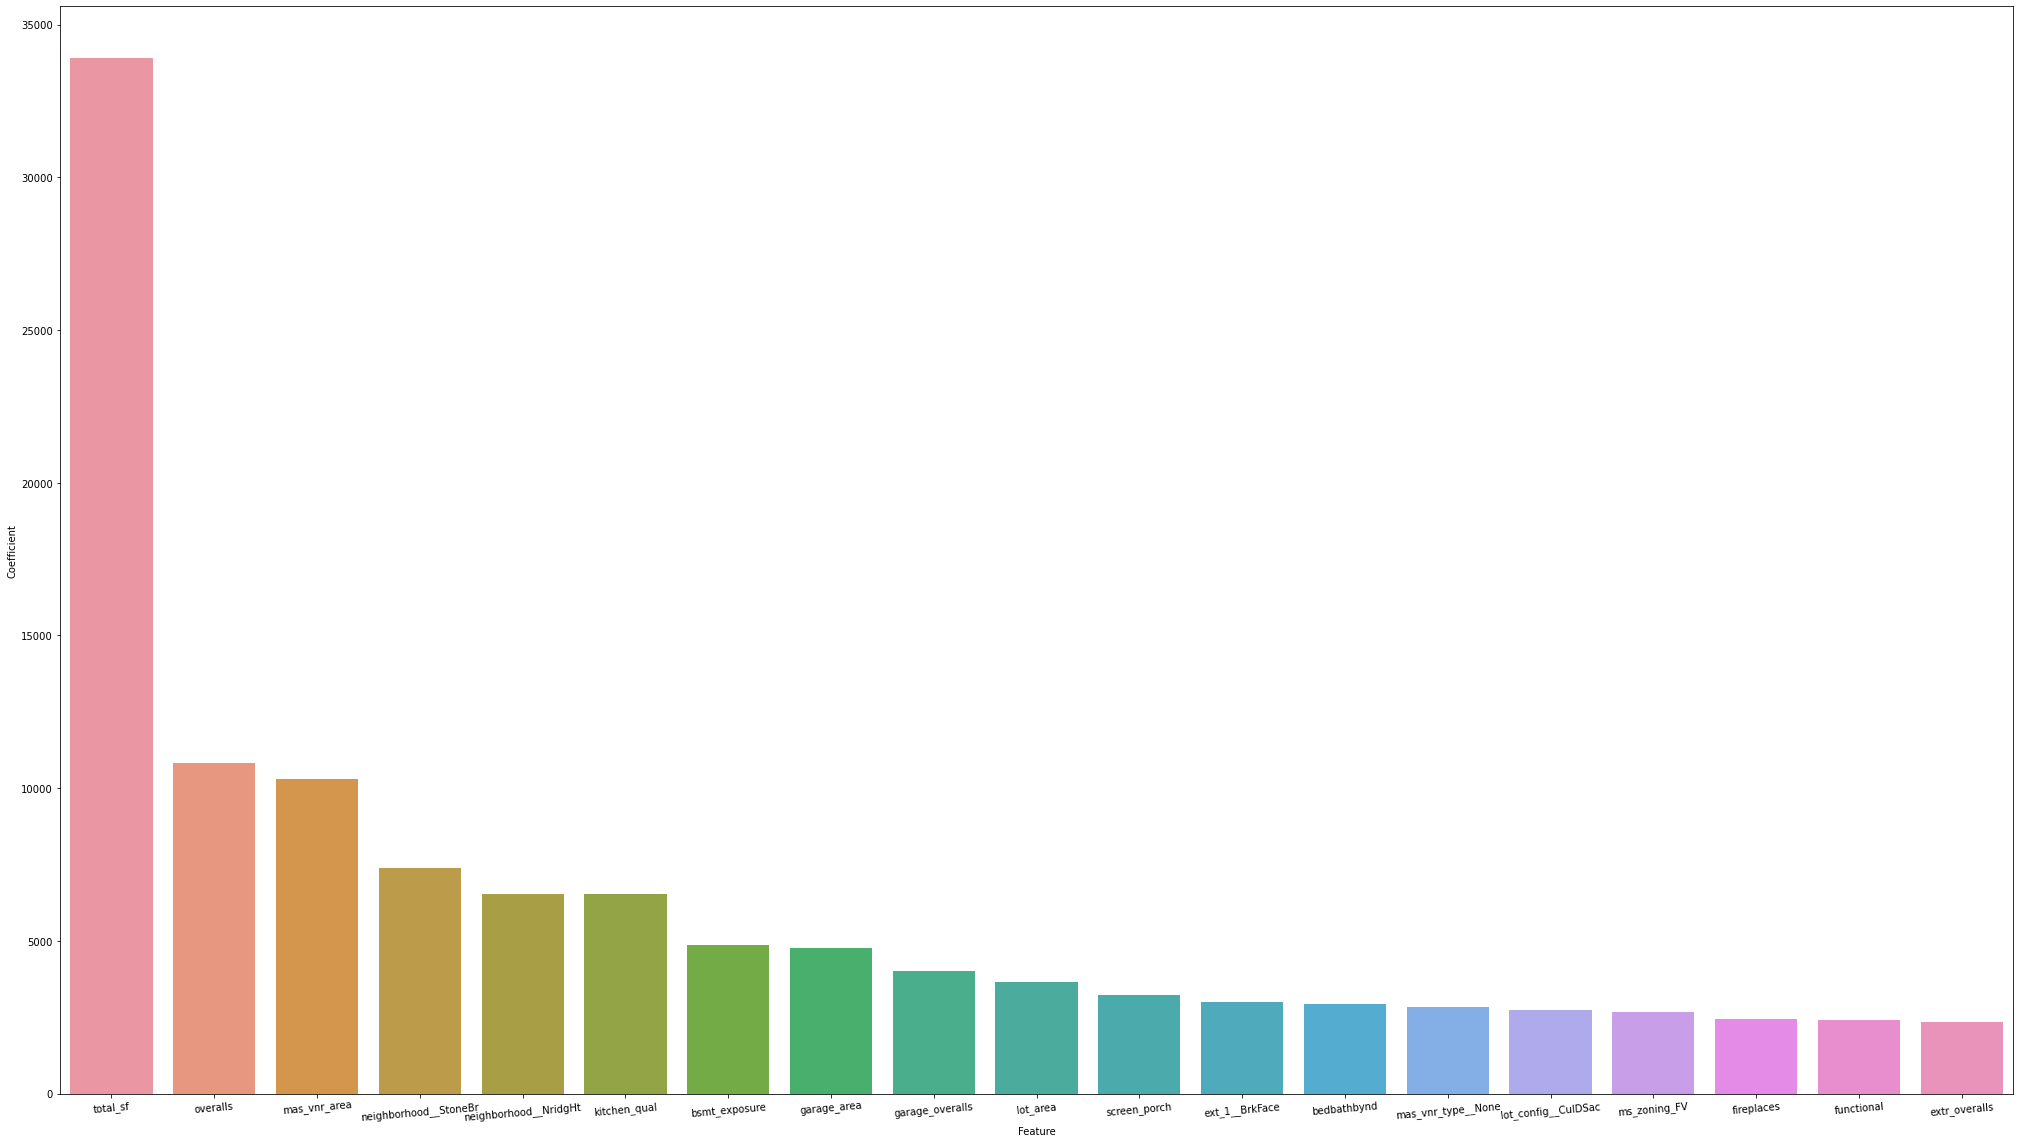

In [158]:
#lets make a bar graph of these coefficients, bit too many features to be fully readable
plt.figure(figsize=(35,20))

sns.barplot(data=abv_av_coefs.sort_values('Coefficient', ascending= False), 
            x= 'Feature', y= 'Coefficient')
plt.xticks(rotation = 5);

In [159]:
#lets look at what the above average coefficients in this model are
abv_av_coefs.sort_values('Coefficient', ascending=False)

,Feature,Coefficient
163,total_sf,33900.492523
164,overalls,10824.971313
8,mas_vnr_area,10311.014145
89,neighborhood__StoneBr,7400.168884
83,neighborhood__NridgHt,6548.896257
21,kitchen_qual,6541.586649
9,bsmt_exposure,4858.930733
26,garage_area,4765.452691
167,garage_overalls,4013.005694
2,lot_area,3656.044680


#### Interpretation of the top 19 Coefficients

These top coefficients are not all that different from the features that were included in the common features model. We can group these features by:
1. Total Square Footage of the home
1. Varying Neighborhood Locations for the home
1. Quality of important parts of the home
    * Kitchen most important
    * Basement and the garage are next most important
    * Having a Brick Exterior
1. Size of the lot
1. Number of rooms in the home
1. Suburban location (Cul De Sac location or A Floating Village Residential Area)

There are two features on this list that stand out as important for a first time home-buyer to consider:
1. Having a Screen porch is the 11th most important factor in the price of a home in this dataset. Put another way if someone were looking at ways to save money on a first house looking for a house that doesn't have a screen porch could lower the price of that home.
2. Fireplaces were the 17th most important factor in the price of a home. Similar to a screen porch, looking for a home without a fireplace is likely to lower the price as well.

#### MSE & RMSE of the Training Data

In [160]:
preds = lasso_cv.predict(X_test_sc)

In [161]:
#MSE Scores
print('MSE Train:', round(mean_squared_error(y_true= y_train, y_pred= lasso_cv.predict(X_train_sc)), 2))
print('MSE Test:', round(mean_squared_error(y_true= y_test, y_pred= lasso_cv.predict(X_test_sc)), 2))

MSE Train: 512977690.8
MSE Test: 587625129.5


In [162]:
#RMSE Scores
print('MSE Train:', round((mean_squared_error(y_true= y_train, y_pred= lasso_cv.predict(X_train_sc)) ** .5), 2))
print('MSE Test:', round((mean_squared_error(y_true= y_test, y_pred= lasso_cv.predict(X_test_sc)) ** .5), 2))

MSE Train: 22649.01
MSE Test: 24240.98


In [163]:
saleprice = lasso_cv.predict(X_test_sc)

In [164]:
train_numeric.columns

Index(['ms_subclass', 'lot_frontage', 'lot_area', 'lot_shape', 'utilities',
       'land_slope', 'year_built', 'year_remod/add', 'mas_vnr_area',
       'bsmt_exposure',
       ...
       'garage_type_CarPort', 'garage_type_Detchd', 'misc_feat__Othr',
       'misc_feat__Shed', 'total_sf', 'overalls', 'extr_overalls',
       'bedbathbynd', 'garage_overalls', 'saleprice'],
      dtype='object', length=169)

### EDA and Setting Predictions on the Test Data 

In [165]:
test_df = pd.read_csv('./datasets/test.csv')

In [166]:
#converting columns
test_df.rename(str.lower, axis=1, inplace=True)
test_df.columns = test_df.columns.str.replace(' ', '_')

In [167]:
### One Hot Encode or Dummy variables to transform categorical variables into a format that can be used in regression
ms_subclass = pd.get_dummies(data=test_df['ms_subclass'], prefix= 'ms_subclass', drop_first=True)
ms_zoning   = pd.get_dummies(data=test_df['ms_zoning'], prefix= 'ms_zoning', drop_first=True)
street      = pd.get_dummies(data=test_df['street'], prefix= 'access_', drop_first=True)
alley       = pd.get_dummies(data=test_df['alley'], prefix= 'alley_', drop_first=True)
land_countour = pd.get_dummies(data=test_df['land_contour'], prefix= 'land_contour_', drop_first=True)
lot_config  = pd.get_dummies(data=test_df['lot_config'], prefix= 'lot_config_', drop_first=True)
neighborhood  = pd.get_dummies(data=test_df['neighborhood'], prefix='neighborhood_', drop_first=True)
condition_1 = pd.get_dummies(test_df['condition_1'], prefix= 'cnd_1_', drop_first=True)
condition_2 = pd.get_dummies(test_df['condition_2'], prefix= 'cnd_2_', drop_first=True)
bldg_type   = pd.get_dummies(test_df['bldg_type'], prefix= 'bldg_type_', drop_first=True)
house_style  = pd.get_dummies(test_df['house_style'], prefix= 'house_style_', drop_first=True)
roof_style  = pd.get_dummies(test_df['roof_style'], prefix= 'roof_style_', drop_first=True)
roof_matl   = pd.get_dummies(test_df['roof_matl'], prefix= 'roof_matl_', drop_first=True)
extr_1      = pd.get_dummies(test_df['exterior_1st'], prefix = 'ext_1_', drop_first=True)
extr_2      = pd.get_dummies(test_df['exterior_2nd'], prefix = 'ext_2_', drop_first=True)
mas_vnr_type = pd.get_dummies(test_df['mas_vnr_type'], prefix = 'mas_vnr_type_', drop_first=True)
foundation  = pd.get_dummies(test_df['foundation'], prefix= 'foundation_', drop_first=True)
heating     = pd.get_dummies(test_df['heating'], prefix= 'heating_', drop_first=True)
central_air = pd.get_dummies(test_df['central_air'], prefix= 'central_air_', drop_first=True)
garage_type = pd.get_dummies(test_df['garage_type'], prefix= 'garage_type', drop_first=True)
misc_feat   = pd.get_dummies(test_df['misc_feature'], prefix='misc_feat_', drop_first=True)

test_dummies=[ms_subclass, ms_zoning, street, alley, land_countour, lot_config, neighborhood, condition_1, condition_2, bldg_type, house_style, roof_style, roof_matl,
        extr_1, extr_2, mas_vnr_type, foundation, heating, central_air, garage_type, misc_feat]

In [168]:
for dummy in test_dummies:
    test_df = test_df.join(other=dummy)
    
print(test_df.columns)

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour',
       ...
       'heating__GasW', 'heating__Grav', 'central_air__Y',
       'garage_type_Attchd', 'garage_type_Basment', 'garage_type_BuiltIn',
       'garage_type_CarPort', 'garage_type_Detchd', 'misc_feat__Othr',
       'misc_feat__Shed'],
      dtype='object', length=211)


In [169]:
# casting/mapping out ordinal variables
test_df['lot_shape'] = test_df['lot_shape'].map({'Reg': 4, 'IR1' : 3, 'IR2' : 2, 'IR3' : 1})
test_df['utilities'] = test_df['utilities'].map({'AllPub': 1, 'NoSewr' : 0, 'NoSeWa' : 0, 'ELO' : 0})
test_df['land_slope'] = test_df['land_slope'].map({'Gtl' : 3, 'Mod': 2, 'Sev': 1})
test_df['bsmt_cond'] = test_df['bsmt_cond'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1,})
test_df['bsmt_exposure'] = test_df['bsmt_exposure'].map({'Gd': 3, 'Av' : 2, 'Mn' : 1, 'No' : 0, 0: 0})
test_df['bsmtfin_type_1'] = test_df['bsmtfin_type_1'].map({'GLQ' : 4, 'ALQ' : 3, 'BLQ' : 2, 'Rec' : 3, 'LwQ' : 1, 'Unf' : 1, 0 : 0})
test_df['bsmtfin_type_2'] = test_df['bsmtfin_type_2'].map({'GLQ' : 4, 'ALQ' : 3, 'BLQ' : 2, 'Rec' : 3, 'LwQ' : 1, 'Unf' : 1, 0 : 0})
test_df['heating_qc'] = test_df['heating_qc'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1})
test_df['electrical'] = test_df['electrical'].map({'Sbrkr' : 4, 'FuseA' : 3, 'FuseF' : 2, 'FuseP' : 1, 'Mix' : 2})
test_df['kitchen_qual'] = test_df['kitchen_qual'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1})
test_df['functional'] = test_df['functional'].map({'Typ': 7, 'Min1' : 6, 'Min2' : 5, 'Mod' : 4, 'Maj1' : 3, 'Maj2' : 2, 'Sev' : 1, 'Sal' : 0})
test_df['fireplace_qu'] = test_df['fireplace_qu'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1, 0 : 0})
test_df['garage_finish'] = test_df['garage_finish'].map({'Fin': 3, 'RFn' : 2, 'Unf' : 1, 0 :0})
test_df['garage_qual'] = test_df['garage_qual'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1})
test_df['garage_cond'] = test_df['garage_cond'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 0 : 0})
test_df['paved_drive'] = test_df['paved_drive'].map({'Y' : 2, 'P' : 1, 'N' : 0})
test_df['pool_qc'] = test_df['pool_qc'].map({'Ex' : 4, 'Gd' : 3, 'TA' : 2, 'Fa' : 1, 0 : 0})
test_df['fence'] = test_df['fence'].map({'GdPrv': 4, 'MnPrv' : 3, 'GdWo' : 2, 'MnWw' : 1, 'no' : 0})
test_df['exter_cond'] = test_df['exter_cond'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1, 0 : 0})
test_df['exter_qual'] = test_df['exter_qual'].map({'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1, 0 : 0})

In [170]:
mapping_features = ['lot_shape','utilities', 'land_slope','bsmt_cond','bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2', 'heating_qc',
                    'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive',
                    'pool_qc', 'fence','exter_cond','exter_qual']

In [171]:
def col_to_int_no_nulls2(col):
    if test_df[col].isna().sum() <1:
            test_df[col] = train[col].map(lambda col : int(col))
    else:
        test_df[col].fillna(0, inplace = True)
        test_df[col] = train[col].map(lambda col : int(col))
    
    return test_df[col].value_counts()

In [172]:
[col_to_int_no_nulls2(feature) for feature in mapping_features]

[4    554
 3    302
 2     20
 1      2
 Name: lot_shape, dtype: int64,
 1    876
 0      2
 Name: utilities, dtype: int64,
 3    832
 2     38
 1      8
 Name: land_slope, dtype: int64,
 3    782
 4     38
 2     30
 0     24
 1      2
 5      2
 Name: bsmt_cond, dtype: int64,
 0    614
 2    114
 3     92
 1     58
 Name: bsmt_exposure, dtype: int64,
 1    298
 4    265
 3    212
 2     79
 0     24
 Name: bsmtfin_type_1, dtype: int64,
 1    771
 3     52
 0     24
 2     18
 4     13
 Name: bsmtfin_type_2, dtype: int64,
 5    463
 3    261
 4    122
 2     31
 1      1
 Name: heating_qc, dtype: int64,
 0    798
 3     61
 2     13
 1      6
 Name: electrical, dtype: int64,
 3    448
 4    335
 5     67
 2     28
 Name: kitchen_qual, dtype: int64,
 7    812
 4     19
 5     18
 6     18
 3      6
 2      3
 0      1
 1      1
 Name: functional, dtype: int64,
 0    469
 4    196
 3    159
 2     26
 5     16
 1     12
 Name: fireplace_qu, dtype: int64,
 1    361
 2    254
 3    211
 0

In [173]:
#feature interactions 
test_df['total_sf'] = test_df['total_bsmt_sf'] + test_df['gr_liv_area']

test_df['overalls'] = test_df['overall_cond'] * test_df['overall_qual']

test_df['extr_overalls'] = test_df['exter_cond'] * test_df['exter_qual']

test_df['bedbathbynd']  = test_df['full_bath'] * test_df['totrms_abvgrd'] * test_df['bedroom_abvgr']

test_df['bsmt_overall'] = test_df['bsmt_cond'] * test_df['bsmt_qual']

test_df['garage_overalls'] = test_df['garage_qual'] * test_df['garage_cond'] * test_df['garage_finish'] * test_df['garage_cars']

In [174]:
#from hackathon find found here (https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas)
numerics = ['uint8', 'float64', 'int32', 'float16', 'float32', 'int64']

test_numeric = test_df.select_dtypes(include=numerics)

In [175]:
test_numeric.drop(columns=['total_bsmt_sf', 'gr_liv_area', 'overall_cond', 'overall_qual', 'exter_cond', 'exter_qual', 'full_bath', 'half_bath', 'totrms_abvgrd',
                            'bedroom_abvgr', 'bsmt_cond', 'garage_qual', 'garage_cond', 'garage_finish', 'garage_cars', '1st_flr_sf', '2nd_flr_sf'], inplace=True)

In [176]:
test_numeric['year_built']     = 2010 - test_numeric['year_built']
test_numeric['year_remod/add'] = 2010 - test_numeric['year_remod/add']

In [177]:
test_numeric.isna().sum()

id                   0
pid                  0
ms_subclass          0
lot_frontage       160
lot_area             0
                  ... 
total_sf             0
overalls             0
extr_overalls        0
bedbathbynd          0
garage_overalls      0
Length: 177, dtype: int64

In [178]:
test_numeric.fillna(0, inplace= True)

In [183]:
[i for i in train_numeric.columns if i not in test_numeric.columns]

['saleprice']

In [184]:
[i for i in test_numeric.columns if i not in train_numeric.columns]

['id',
 'pid',
 'roof_matl__Metal',
 'roof_matl__Roll',
 'ext_1__PreCast',
 'ext_2__Other',
 'ext_2__PreCast',
 'mas_vnr_type__CBlock',
 'heating__GasA']

In [186]:
test_numeric.drop(columns=['id',
 'pid',
 'roof_matl__Metal',
 'roof_matl__Roll',
 'ext_1__PreCast',
 'ext_2__Other',
 'ext_2__PreCast',
 'mas_vnr_type__CBlock',
 'heating__GasA'], inplace=True)

In [180]:
test_numeric.columns

Index(['id', 'pid', 'ms_subclass', 'lot_frontage', 'lot_area', 'lot_shape',
       'utilities', 'land_slope', 'year_built', 'year_remod/add',
       ...
       'garage_type_BuiltIn', 'garage_type_CarPort', 'garage_type_Detchd',
       'misc_feat__Othr', 'misc_feat__Shed', 'total_sf', 'overalls',
       'extr_overalls', 'bedbathbynd', 'garage_overalls'],
      dtype='object', length=177)

In [187]:
X= test_numeric

In [190]:
test_numeric['saleprice'] = lr.predict(X)

In [ ]:
test_numeric['i']

In [192]:
test_numeric = test_numeric.join(other=test_df['id'])

In [194]:
test_numeric['id']

0      2658
1      2718
2      2414
3      1989
4       625
       ... 
873    1662
874    1234
875    1373
876    1672
877    1939
Name: id, Length: 878, dtype: int64

In [195]:
complex_model_submit = test_numeric[['id', 'saleprice']]

In [196]:
complex_model_submit.set_index('id', inplace=True)

In [197]:
complex_model_submit.to_csv('./datasets/complex_model_submit.csv')